<a href="https://colab.research.google.com/github/pinballsurgeon/deluxo_adjacency/blob/main/LLM_Alignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

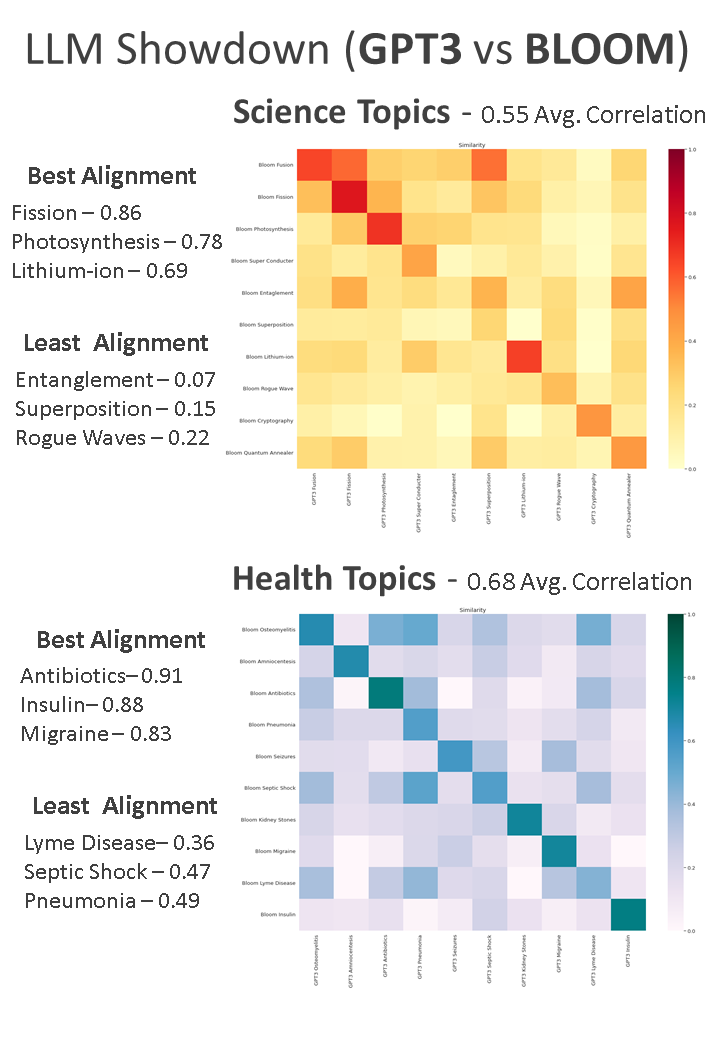

Note: Enable CUDA GPUs in runtime settings 

Install

In [ ]:
# install transformers
!pip install transformers -q

# install openai
!pip install openai

Import

In [2]:
# standard dan-dard
import os
import io
import re
import numpy
import pandas
import string
import seaborn

# pytorch
import torch
torch.set_default_tensor_type(torch.cuda.FloatTensor)

# tensorflow
import tensorflow_hub
import tensorflow as tf
from tensorboard.plugins import projector
from tensorflow.keras.layers import TextVectorization
 
# universal encoder
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
encoder_model = tensorflow_hub.load(module_url)

# set up a logs directory, so Tensorboard knows where to look for files.
log_dir='/logs/embedding_projector/'
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

# LM transformers
from transformers import AutoModelForCausalLM, AutoTokenizer, set_seed

# gpt3 
import openai

# supply openai api key via file 
openai.api_key = open('openai_key').read()

# load tensorboar dextension
%load_ext tensorboard

# neet to better understand beam group parameters, until then ignore their warnings
import warnings
warnings.filterwarnings('ignore')

Download

In [3]:
model = AutoModelForCausalLM.from_pretrained("bigscience/bloom-1b3", use_cache=True)
tokenizer = AutoTokenizer.from_pretrained("bigscience/bloom-1b3")

Template

In [32]:
science_topics = [ 'Fusion', 'Fission', 'Photosynthesis'
                 , 'Super Conducter', 'Entaglement', 'Superposition'
                 , 'Lithium-ion', 'Rogue Wave', 'Cryptography', 'Quantum Annealer']

health_topics = [ 'Osteomyelitis', 'Amniocentesis', 'Antibiotics'
                , 'Pneumonia', 'Seizures', 'Septic Shock'
                , 'Kidney Stones', 'Migraine', 'Lyme Disease', 'Insulin']


request_sentence = 'What is %s'
regex = re.compile('[^a-zA-Z ]')

Helper functions

In [5]:
### OPENAI - Ask Davinci - build openai completion request, define parameters
def get_openai_response(question):

    # format open au request
    response = openai.Completion.create(
                      engine="text-davinci-001",
                      prompt=question,
                      temperature=.5,
                      max_tokens=250,
                      top_p=1,
                      frequency_penalty=50,
                      presence_penalty=0 )

    # parse and process open ai response
    response_choices = response["choices"]

    # replace blanks
    response = response_choices[0]["text"].strip()
    
    # replace non-alphabet chars
    response = regex.sub('', response)

    return response

In [6]:
### OPENAI - Form Davinci request
def prompt_openai(topic, request_template):
  
  # build sentence and retrieve 
  retrieval = get_openai_response(request_template % topic)
  
  # return response
  return retrieval

In [15]:
### BLOOM - Generate Bloom response model
def get_bloom_response(question):

  response = model.generate(**question
                          , num_beams = 2
                          , num_beam_groups = 2
                          , top_k=1
                          , temperature=0.9
                          , repetition_penalty = 2.0
                          , diversity_penalty=2.0
                          , max_new_tokens = 20)
  
  return response


In [8]:
### BLOOM - Form request
def prompt_bloom(topic, request_template):

  # initiate tokenizer
  input_tokens = tokenizer(request_template % topic, return_tensors="pt").to(0)

  # build sentence and retrieve 
  retrieval = get_bloom_response(input_tokens)

  # decode retrieval
  retrieval = tokenizer.decode(retrieval[0], truncate_before_pattern=[r"\n\n^#", "^'''","\n\n\n"])

  # remove prompt from response
  retrieval = retrieval.replace(request_template % topic, '')

  # replace blanks
  retrieval = retrieval.strip()
  
  # replace non-alphabet chars
  retrieval = regex.sub('', retrieval)

  return retrieval


In [30]:
### ITERATE TOPICS - process topics through LLMs

def llm_iter(topics):

  # initiate buffer
  df = pandas.DataFrame(columns=['Topic','Openai_response','Bloom_response'])

  # iterate through topics
  for topic in topics:

    # prompt our language models
    openai_response = prompt_openai(topic, request_sentence)
    bloom_response = prompt_bloom(topic, request_sentence)

    # populate buffer
    df.loc[len(df.index)] = [topic, openai_response, bloom_response]

  # return buffer
  return df

In [35]:
### UNIVERSAL ENCODER - embed and correlate topic matrices
def embedd_and_correlate(df, colormap_):

  # embed sentences
  openai_embeddings_ = encoder_model(df['Openai_response'])
  bloom_embeddings_ = encoder_model(df['Bloom_response'])

  # array product (build our 2d universe)
  corr = numpy.inner(openai_embeddings_, bloom_embeddings_)

  # seaborn config
  seaborn.set(font_scale=1.2, rc={'figure.figsize':(20,15)})

  # seaborn plot
  g = seaborn.heatmap(
      corr,
      xticklabels='GPT3 ' + df['Topic'].str.slice(0,25), # vect GPT3 responses
      yticklabels='Bloom ' + df['Topic'].str.slice(0,25), # vect Bllom responses
      vmin=0,
      vmax=1,
      cmap=colormap_)

  # rotate and label
  g.set_xticklabels('GPT3 ' + df['Topic'].str.slice(0,25), rotation=90)
  g.set_title("Similarity")


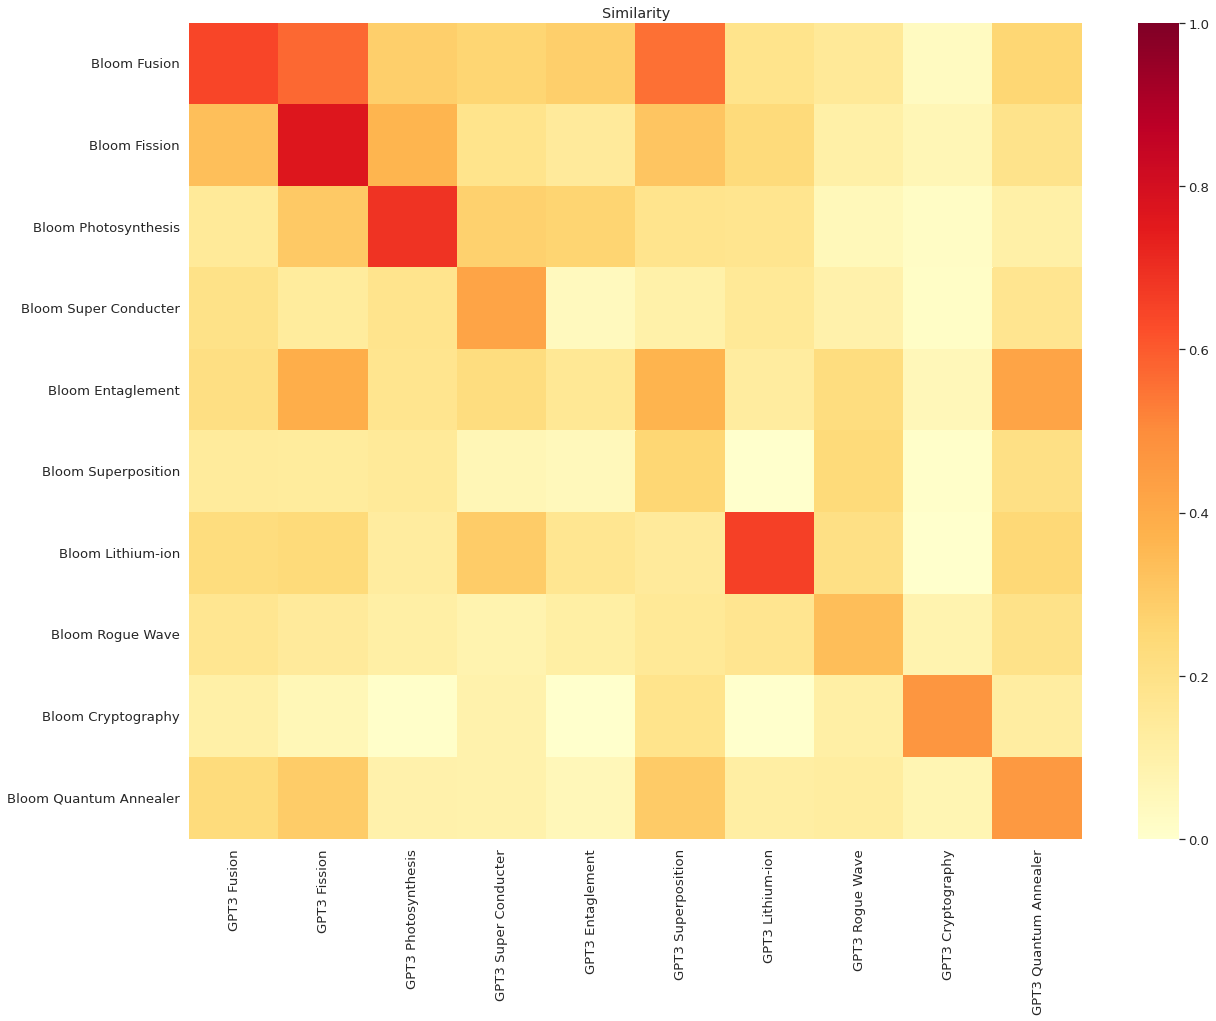

In [33]:
# compare science topics
embedd_and_correlate(llm_iter(science_topics), "YlOrRd")

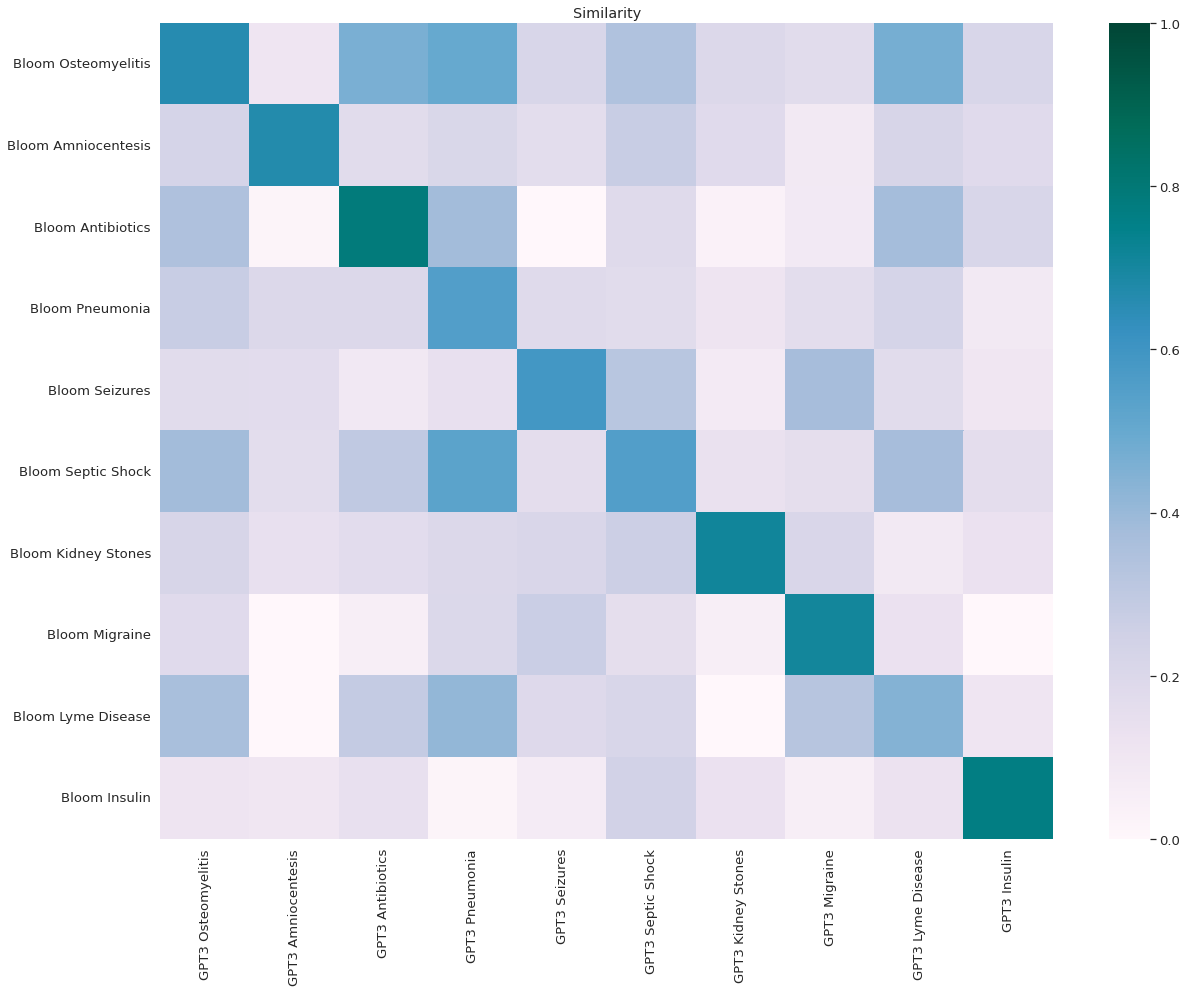

In [36]:
# compare health topics
embedd_and_correlate(llm_iter(health_topics), 'PuBuGn')

In [ ]:
# End 